In [1]:
#%reset
import tensorflow as tf
import os,sys
import glob
from IPython.display import Image
sys.path.append('/home/dagutman/devel/tensorflow-vgg/')
#import vgg16
import vgg19_trainable as vgg19
from scipy.misc import imread
import numpy as np

In [2]:
n_classes = 2
LEARN_RATE = 1e-6
n_epochs = 10

In [3]:
tf.reset_default_graph()

model = vgg19.Vgg19('./vgg19.npy')

# Placehol\ders and feed data
with tf.name_scope("graph_inputs"):
    model.images = tf.placeholder("float", shape=[None, 224, 224, 3])
    model.labels = tf.placeholder("float", shape=[None, n_classes])

# Actual model
with tf.name_scope("vgg19_content"):
    model.build(model.images)

In [4]:
"""This module provides the a softmax cross entropy loss for training FCN.
In order to train VGG first build the model and then feed apply vgg_fcn.up
to the loss. The loss function can be used in combination with any optimizer
(e.g. Adam) to finetune the whole model.
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

def loss(logits, labels, num_classes, head=None):
    """Calculate the loss from the logits and the labels.
    Args:
      logits: tensor, float - [batch_size, num_classes].
          Use vgg_fcn.upscore as logits.
      labels: Labels tensor, int32 - [batch_size, num_classes].
          The ground truth of your data.
      head: numpy array - [num_classes]
          Weighting the loss of each class
          Optional: Prioritize some classes
    Returns:
      loss: Loss tensor of type float.
    """
    with tf.name_scope('loss'):
        
        logits = tf.reshape(logits, (-1, num_classes))
        labels = tf.to_float(tf.reshape(labels, (-1, num_classes)))
        
        epsilon = tf.constant(value=1e-4)
        logits = tf.nn.softmax(logits) + epsilon

        if head is not None:
            cross_entropy = -tf.reduce_sum(tf.multiply(labels * tf.log(logits),
                                           head), reduction_indices=[1])
        else:
            cross_entropy = -tf.reduce_sum(
                labels * tf.log(logits), reduction_indices=[1])

        cross_entropy_mean = tf.reduce_mean(cross_entropy,
                                            name='xentropy_mean')
        tf.add_to_collection('losses', cross_entropy_mean)

        loss = tf.add_n(tf.get_collection('losses'), name='total_loss')
    return loss

In [5]:
[n.name for n in tf.get_default_graph().as_graph_def().node]

[u'graph_inputs/Placeholder',
 u'graph_inputs/Placeholder_1',
 u'vgg19_content/mul/y',
 u'vgg19_content/mul',
 u'vgg19_content/Const',
 u'vgg19_content/split/split_dim',
 u'vgg19_content/split',
 u'vgg19_content/sub/y',
 u'vgg19_content/sub',
 u'vgg19_content/sub_1/y',
 u'vgg19_content/sub_1',
 u'vgg19_content/sub_2/y',
 u'vgg19_content/sub_2',
 u'vgg19_content/concat/axis',
 u'vgg19_content/concat',
 u'vgg19_content/conv1_1/truncated_normal/shape',
 u'vgg19_content/conv1_1/truncated_normal/mean',
 u'vgg19_content/conv1_1/truncated_normal/stddev',
 u'vgg19_content/conv1_1/truncated_normal/TruncatedNormal',
 u'vgg19_content/conv1_1/truncated_normal/mul',
 u'vgg19_content/conv1_1/truncated_normal',
 u'vgg19_content/conv1_1/conv1_1_filters/initial_value',
 u'vgg19_content/conv1_1/conv1_1_filters',
 u'vgg19_content/conv1_1/conv1_1_filters/Assign',
 u'vgg19_content/conv1_1/conv1_1_filters/read',
 u'vgg19_content/conv1_1/truncated_normal_1/shape',
 u'vgg19_content/conv1_1/truncated_normal_1/

In [6]:
model.cost = loss(model.prob, model.labels, num_classes=n_classes)

In [7]:
model.optimizer = tf.train.AdamOptimizer(LEARN_RATE).minimize(model.cost)

In [8]:
brcaThumbs_Train_Path = '/home/dagutman/devel/DSA_CBIR_Prototypes/dataSetGeneration/localCache/Exp1_BRCA_vs_GBM/TRAINING/BRCA_Thumbs/*.jpg'
gbmThumbs_Train_Path = '/home/dagutman/devel/DSA_CBIR_Prototypes/dataSetGeneration/localCache/Exp1_BRCA_vs_GBM/TRAINING/GBM_Thumbnails/*.jpg'

In [9]:
brcaThumbs_Train = glob.glob(brcaThumbs_Train_Path)
gbmThumbs_Train = glob.glob(gbmThumbs_Train_Path)

In [10]:
modelImageData = []

#gbm is class 0
for x in gbmThumbs_Train:
    modelImageData.append( (x,0) )                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
    
#brca is class 1
for x in brcaThumbs_Train:
    modelImageData.append( (x,1) )


In [11]:
print(modelImageData[2])

('/home/dagutman/devel/DSA_CBIR_Prototypes/dataSetGeneration/localCache/Exp1_BRCA_vs_GBM/TRAINING/GBM_Thumbnails/TCGA-06-0875-01Z-00-DX1.c04e2f8e-868d-455b-88b0-af5ee89bf319.svs.macrothumb.jpg', 0)


In [12]:
# Initialize
batch_size = 1
images = np.zeros([batch_size, 224, 224, 3])
labels = np.zeros([batch_size, n_classes])

In [13]:
print(images.shape)
print(labels[0, :])

(1, 224, 224, 3)
[ 0.  0.]


In [14]:
from random import shuffle

shuffle(modelImageData)


with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    print("epoch\timidx\tcost")
    print("-------------------")
    
    costs = []
    
    for epoch in range(n_epochs):
        
        # load image and label
        for imidx, _ in enumerate(modelImageData):
            
            #print(imidx)
            #continue
            
            # read image
            images[0, :, :, :] = imread(modelImageData[imidx][0])
            
            # make a "one-hot" label 
            labels[0, modelImageData[imidx][1]] = 1
        
            feed = {model.images: images,
                   model.labels: labels}

            _, cost = sess.run([model.optimizer, model.cost], feed_dict=feed)
            
            costs.append(cost)

            print("{}\t{}\t{}".format(epoch, imidx, cost))

epoch	imidx	cost
-------------------
0	0	0.694187104702
0	1	0.692187547684
0	2	1.38637459278
0	3	1.38637459278
0	4	1.38637459278
0	5	1.38637280464
0	6	1.38637459278
0	7	1.38637471199
0	8	1.38637471199
0	9	1.38637459278
0	10	1.38637459278
0	11	1.38637471199
0	12	1.38637471199
0	13	1.38637459278
0	14	1.38630640507
0	15	1.38637471199
0	16	1.38637471199
0	17	1.38637471199
0	18	1.38637471199
0	19	1.38637471199
0	20	1.38637471199
0	21	1.38637471199
0	22	1.38637471199
0	23	1.38637447357
0	24	1.38637471199
0	25	1.38637471199
0	26	1.38637459278
0	27	1.38637471199
0	28	1.38637387753
0	29	1.38637471199
0	30	1.38637471199
0	31	1.38637471199
0	32	1.38637459278
0	33	1.38637459278
0	34	1.38637471199
0	35	1.38637471199
0	36	1.38637459278
0	37	1.38637459278
0	38	1.38637471199
0	39	1.38637459278
0	40	1.38637471199
0	41	1.38637471199
0	42	1.38637471199
0	43	1.38637471199
0	44	1.38637459278
0	45	1.38637471199
0	46	1.38637459278
0	47	1.38637459278
0	48	1.38637459278
0	49	1.38637471199
0	50	1.38637459278
0	

KeyboardInterrupt: 

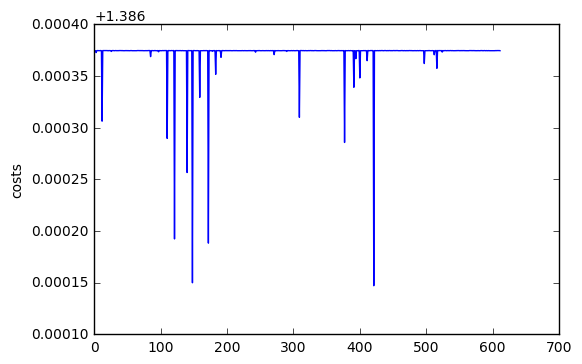

In [17]:
import matplotlib.pyplot as plt
plt.plot(costs[2:])
plt.ylabel('costs')
plt.show()

imnageData

In [16]:
tf.reset_default_graph()